In [2]:
DATA_ROOT = '/scratch/DL24FA'

In [3]:
import numpy as np
import os

# Paths to the data files
states_path = os.path.join(DATA_ROOT, 'train', 'states.npy')
actions_path = os.path.join(DATA_ROOT, 'train', 'actions.npy')

# Load the data with memory mapping for faster reads
try:
    states = np.load(states_path, mmap_mode='r')
    actions = np.load(actions_path, mmap_mode='r')
    print(f"States shape: {states.shape}")
    print(f"Actions shape: {actions.shape}")
except FileNotFoundError:
    print("Error: Data files not found. Please ensure the paths are correct and accessible.")


States shape: (147008, 17, 2, 65, 65)
Actions shape: (147008, 16, 2)


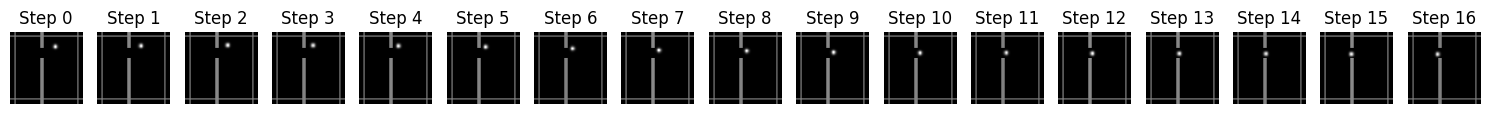

In [4]:
import matplotlib.pyplot as plt

# Visualizing a single trajectory (states and actions)
def visualize_trajectory(states, actions, trajectory_index=0):
    """
    Visualizes the given trajectory with agent positions and walls.
    """
    trajectory_states = states[trajectory_index]
    trajectory_actions = actions[trajectory_index]
    
    num_steps = trajectory_states.shape[0]
    fig, axes = plt.subplots(1, num_steps, figsize=(15, 5))
    
    for i, ax in enumerate(axes):
        if i < num_steps:
            # The two channels of the state image
            agent_layer = trajectory_states[i, 0]  # Agent position
            walls_layer = trajectory_states[i, 1]  # Walls and borders
            
            # Combine the layers for visualization
            combined_image = agent_layer + walls_layer * 0.5
            
            ax.imshow(combined_image, cmap='gray')
            ax.set_title(f"Step {i}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the first trajectory
if 'states' in locals() and 'actions' in locals():
    visualize_trajectory(states, actions, trajectory_index=0)

In [5]:
def plot_matrix_with_values(matrix):
    """
    Plots a 2D NumPy matrix with values displayed in each cell.

    Parameters:
    matrix (numpy.ndarray): 2D matrix to be visualized.

    """
    if not isinstance(matrix, np.ndarray) or matrix.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array.")

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust size as needed
    cax = ax.matshow(matrix, cmap='viridis')  # Use a colormap of your choice

    # Add color bar
    fig.colorbar(cax)

    # Display values in each cell
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            value = matrix[i, j]
            # ax.text(j, i, f"{value:.2f}", va='center', ha='center', color='white' if value < matrix.max() / 2 else 'black')

    # Set axis labels
    ax.set_xticks(range(matrix.shape[1]))
    ax.set_yticks(range(matrix.shape[0]))
    ax.set_xticklabels(range(1, matrix.shape[1] + 1))
    ax.set_yticklabels(range(1, matrix.shape[0] + 1))
    ax.xaxis.set_ticks_position('bottom')  # Move x-axis ticks to the bottom

    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.title("Matrix Visualization with Values")
    plt.show()

-1.4306358 -1.4306358


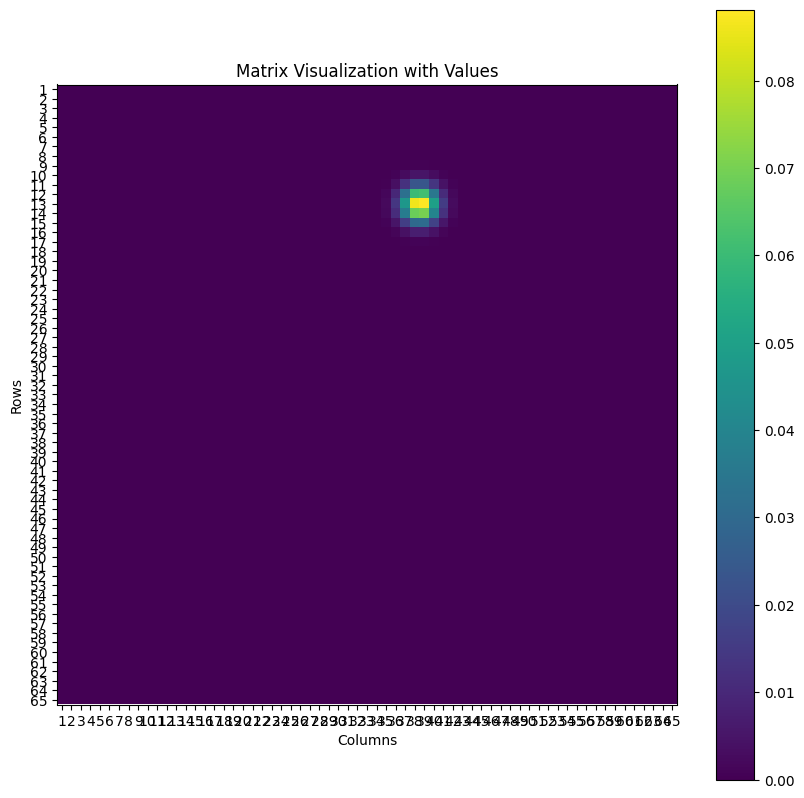

In [6]:
k = 2
print(actions[0][k][0], actions[0][k][0])
plot_matrix_with_values(states[0][k][0])

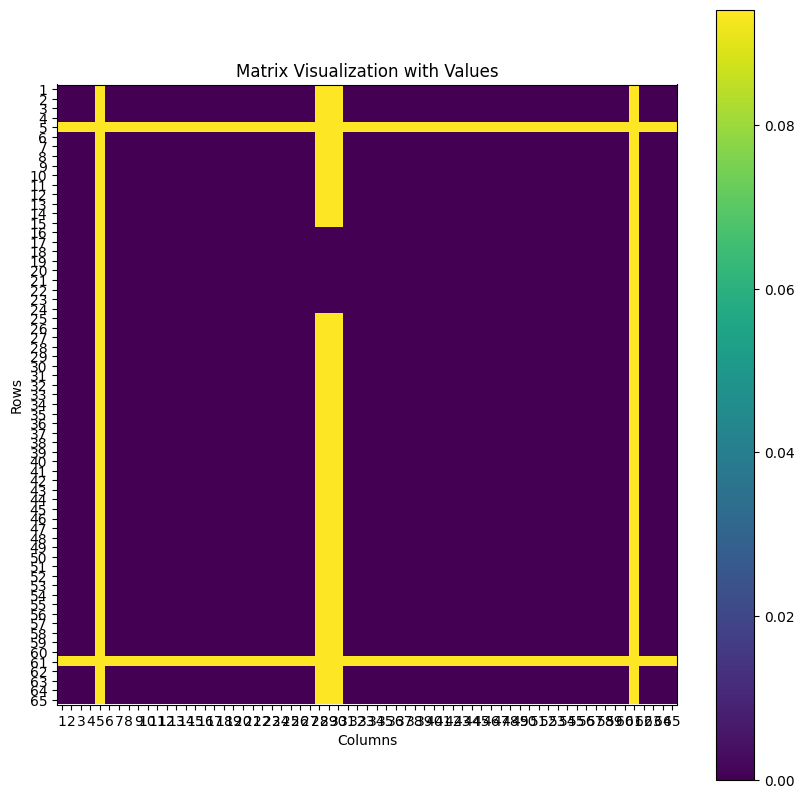

In [7]:
plot_matrix_with_values(states[0][0][1])

In [38]:
from scipy.optimize import curve_fit
import numpy as np
from scipy.stats import chi2

# Candidate functions
def gaussian_2d(coords, A, x0, y0, sigma_x, sigma_y, offset):
    x, y = coords
    return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2))) + offset

def quadratic_2d(coords, a, b, c, x0, y0, offset):
    x, y = coords
    return a * (x - x0)**2 + b * (y - y0)**2 + c * (x - x0) * (y - y0) + offset

# Fit and compare models
def fit_and_compare(matrix, window_size=3):
    max_index = np.unravel_index(np.argmax(matrix), matrix.shape)
    row_start = max(max_index[0] - window_size, 0)
    row_end = min(max_index[0] + window_size + 1, matrix.shape[0])
    col_start = max(max_index[1] - window_size, 0)
    col_end = min(max_index[1] + window_size + 1, matrix.shape[1])
    local_region = matrix[row_start:row_end, col_start:col_end]

    x, y = np.meshgrid(
        np.arange(col_start, col_end),
        np.arange(row_start, row_end)
    )
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = local_region.flatten()

    # Fit Gaussian
    initial_guess_gaussian = (matrix.max(), max_index[1], max_index[0], 1, 1, np.min(matrix))
    popt_gaussian, _ = curve_fit(gaussian_2d, (x_flat, y_flat), z_flat, p0=initial_guess_gaussian)

    # Fit Quadratic
    initial_guess_quadratic = (1, 1, 0, max_index[1], max_index[0], np.min(matrix))
    popt_quadratic, _ = curve_fit(quadratic_2d, (x_flat, y_flat), z_flat, p0=initial_guess_quadratic)

    # Compute R² for both
    gaussian_fit = gaussian_2d((x_flat, y_flat), *popt_gaussian)
    quadratic_fit = quadratic_2d((x_flat, y_flat), *popt_quadratic)

    r2_gaussian = 1 - np.sum((z_flat - gaussian_fit)**2) / np.sum((z_flat - np.mean(z_flat))**2)
    r2_quadratic = 1 - np.sum((z_flat - quadratic_fit)**2) / np.sum((z_flat - np.mean(z_flat))**2)

    print("Gaussian R²:", r2_gaussian)
    print("Quadratic R²:", r2_quadratic)

# Example usage
fit_and_compare(states[0, 0, 0])

Gaussian R²: 0.9999999999999933
Quadratic R²: 0.6898397629577253


In [40]:
import numpy as np
from scipy.optimize import curve_fit

def find_subpixel_peak(matrix):
    """
    Finds the coordinates of the peak in a 2D matrix with subpixel precision using a 2D Gaussian fit.

    Parameters:
    matrix (numpy.ndarray): 2D matrix (e.g., 65x65) to find the peak in.

    Returns:
    tuple: Subpixel coordinates (row, column) of the peak.
    """
    if not isinstance(matrix, np.ndarray) or matrix.ndim != 2:
        raise ValueError("Input must be a 2D NumPy array.")

    # Step 1: Find the integer coordinates of the peak
    max_index = np.unravel_index(np.argmax(matrix), matrix.shape)

    # Step 2: Define a 7x7 region around the peak
    window_size = 3  # Half of 7 (7x7 window)
    row_start = max(max_index[0] - window_size, 0)
    row_end = min(max_index[0] + window_size + 1, matrix.shape[0])
    col_start = max(max_index[1] - window_size, 0)
    col_end = min(max_index[1] + window_size + 1, matrix.shape[1])

    # Extract the local region
    local_region = matrix[row_start:row_end, col_start:col_end]

    # Create a grid for the local region
    x, y = np.meshgrid(
        np.arange(col_start, col_end),
        np.arange(row_start, row_end)
    )
    x_flat = x.flatten()
    y_flat = y.flatten()
    z_flat = local_region.flatten()

    # Step 3: Define the Gaussian function
    def gaussian_2d(coords, A, x0, y0, sigma_x, sigma_y, offset):
        x, y = coords
        return A * np.exp(-((x - x0)**2 / (2 * sigma_x**2) + (y - y0)**2 / (2 * sigma_y**2))) + offset

    # Initial guess for the Gaussian parameters
    initial_guess = (matrix.max(), max_index[1], max_index[0], 1, 1, np.min(matrix))

    # Fit the Gaussian model to the data
    popt, _ = curve_fit(gaussian_2d, (x_flat, y_flat), z_flat, p0=initial_guess)

    # Extract the fitted parameters
    _, x0, y0, _, _, _ = popt

    # Subpixel coordinates are the fitted (x0, y0) in the original matrix space
    subpixel_coords = (y0, x0)
    return subpixel_coords

# Example usage with your `states` matrix
k = 2
matrix = states[0][k][0]  # Assuming `states` is a list of matrices
subpixel_coords = find_subpixel_peak(matrix)
print("Subpixel peak coordinates:", subpixel_coords)

Subpixel peak coordinates: (np.float64(12.109711655666242), np.float64(37.539524054123966))


In [41]:
print(states[0, 0, 0].max())
print(np.argmax(states[0, 0, 0]))
print(np.unravel_index(np.argmax(states[0, 0, 0]), states[0, 0, 0].shape))
print(find_subpixel_peak(states[0, 0, 0]))
print(actions[0, 0])

0.09011259
885
(np.int64(13), np.int64(40))
(np.float64(13.376618397511075), np.float64(39.91527172046825))
[-1.2286036 -0.6856939]


In [42]:
import numpy as np

# Initialize lists to store differences and actions
dx_list = []
dy_list = []
ax_list = []
ay_list = []

b = 100

for t in range(1, states.shape[1]):
    p = states[b, t - 1, 0]
    s = states[b, t, 0]

    # x1, y1 = np.unravel_index(np.argmax(s), s.shape)
    # x1, y1 = int(x1), int(y1)

    x1, y1 = find_subpixel_peak(s)

    # x2, y2 = np.unravel_index(np.argmax(p), p.shape)
    # x2, y2 = int(x2), int(y2)

    x2, y2 = find_subpixel_peak(p)

    ax, ay = actions[b, t - 1]

    # Store the differences and actions
    dx_list.append(x2 - x1)
    dy_list.append(y2 - y1)
    ax_list.append(ax)
    ay_list.append(ay)

# Convert lists to numpy arrays for correlation calculation
dx_array = np.array(dx_list)
dy_array = np.array(dy_list)
ax_array = np.array(ax_list)
ay_array = np.array(ay_list)

# Calculate and print the correlation coefficients
correlation_dx_ax = np.corrcoef(dx_array, ax_array)[0, 1]
correlation_dy_ay = np.corrcoef(dy_array, ay_array)[0, 1]

print("Correlation between dx (x2 - x1) and ax:", correlation_dx_ax)
print("Correlation between dy (y2 - y1) and ay:", correlation_dy_ay)

Correlation between dx (x2 - x1) and ax: -0.8134220880961766
Correlation between dy (y2 - y1) and ay: -0.8346932000696854


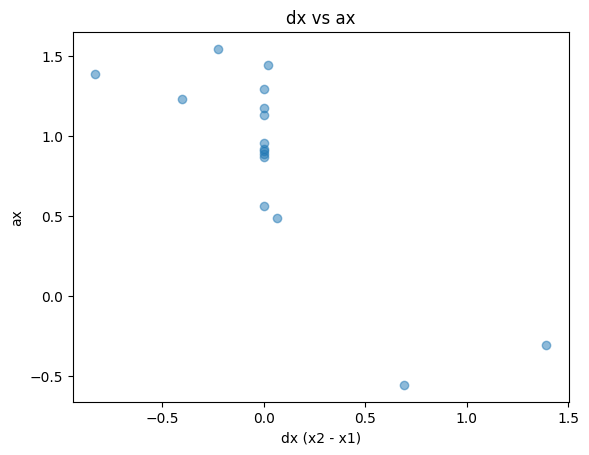

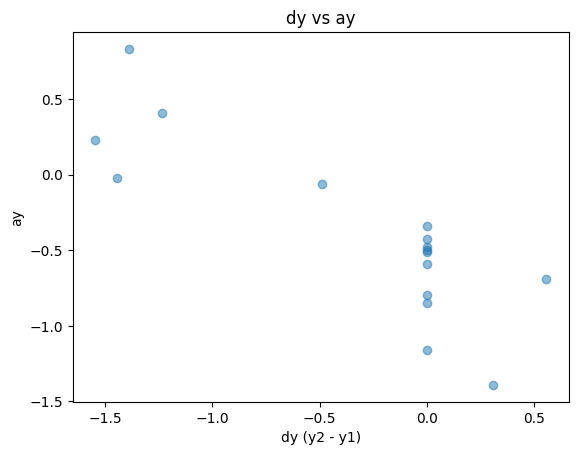

In [43]:
import matplotlib.pyplot as plt

plt.scatter(dx_array, ax_array, alpha=0.5)
plt.title("dx vs ax")
plt.xlabel("dx (x2 - x1)")
plt.ylabel("ax")
plt.show()

plt.scatter(dy_array, ay_array, alpha=0.5)
plt.title("dy vs ay")
plt.xlabel("dy (y2 - y1)")
plt.ylabel("ay")
plt.show()

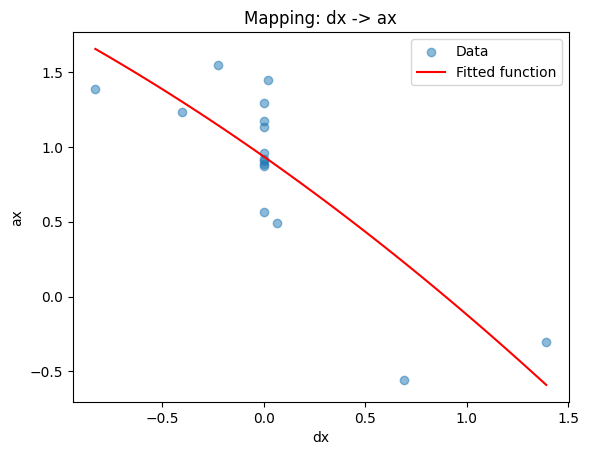

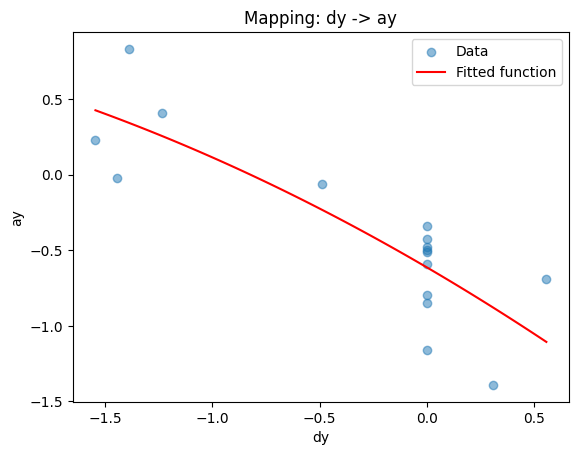

In [46]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def find_mapping_function(dx_array, ax_array, degree=1):
    """
    Finds a mapping function from dx to ax using polynomial regression.

    Parameters:
    dx_array (numpy.ndarray): Array of differences in x (dx or dy).
    ax_array (numpy.ndarray): Array of actions in x (ax or ay).
    degree (int): Degree of the polynomial to fit.

    Returns:
    function: A callable function that maps dx to ax.
    """
    if len(dx_array) != len(ax_array):
        raise ValueError("Input arrays must have the same length.")

    # Reshape the data for fitting
    dx_array = dx_array.reshape(-1, 1)
    ax_array = ax_array.reshape(-1, 1)

    # Create a polynomial regression model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    # Fit the model
    model.fit(dx_array, ax_array)

    # Define the mapping function
    def mapping_function(dx):
        dx = np.array(dx).reshape(-1, 1)
        return model.predict(dx).flatten()

    return mapping_function

# Example usage
# Find the mapping function for dx -> ax
mapping_dx_to_ax = find_mapping_function(dx_array, ax_array, degree=2)

# Find the mapping function for dy -> ay
mapping_dy_to_ay = find_mapping_function(dy_array, ay_array, degree=2)

# Test the mapping functions
dx_test = np.linspace(min(dx_array), max(dx_array), 100)
ax_pred = mapping_dx_to_ax(dx_test)

dy_test = np.linspace(min(dy_array), max(dy_array), 100)
ay_pred = mapping_dy_to_ay(dy_test)

# Plot the results
import matplotlib.pyplot as plt

# Plot dx -> ax
plt.figure()
plt.scatter(dx_array, ax_array, label="Data", alpha=0.5)
plt.plot(dx_test, ax_pred, label="Fitted function", color="red")
plt.title("Mapping: dx -> ax")
plt.xlabel("dx")
plt.ylabel("ax")
plt.legend()
plt.show()

# Plot dy -> ay
plt.figure()
plt.scatter(dy_array, ay_array, label="Data", alpha=0.5)
plt.plot(dy_test, ay_pred, label="Fitted function", color="red")
plt.title("Mapping: dy -> ay")
plt.xlabel("dy")
plt.ylabel("ay")
plt.legend()
plt.show()
